In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from time import sleep

<font color='#2874A6' size=5>
Travelling salesman problem class
</font>

In [2]:
class TSP:
    def __init__(self, n, seed = None):
        if not (isinstance(n, int) and n >= 4):
            raise Exception("n must be an int greater than 3")

        ## Optionally set up the random number
        if seed is not None:
            np.random.seed(seed)
            
        ## Random coordinates in [0,1)x[0,1)
        self.x = np.random.rand(n)
        self.y = np.random.rand(n)
        self.n = n
        self.init_config()


    ## Initialize configuration
    def init_config(self):
        n = self.n
        self.route = np.random.permutation(n)
    
    def dist(self, city1, city2):
        dx2 = (self.x[city1] - self.x[city2])**2
        dy2 = (self.y[city1] - self.y[city2])**2
        return np.sqrt(dx2 + dy2)

    ## Plot the cities and the current configuration
    def display(self):
        x, y = self.x, self.y
        route = self.route

        plt.clf()
        ## Cities locations
        plt.plot(self.x, self.y, 'o')
        ## Route as index so we will get order of route
        plt.plot(x[route], y[route], '-', c='orange')
        ## link the last city to starting point
        xcomeback = [x[route[-1]], x[route[0]]]
        ycomeback = [y[route[-1]], y[route[0]]]
        plt.plot(xcomeback, ycomeback, '-', c='orange')
        ## Pause to actually see something
        display.display(plt.gcf())
        display.clear_output(wait=True)
        sleep(0.4)

    ## Cost of the current configuration
    def cost(self):
        route = self.route
        n = self.n
        c = 0.0
        for e in range(n):
            city1 = route[e]
            city2 = route[(e+1) % n]
            c += self.dist(city1, city2)
        return c

    ## Propose random move
    def propose_move(self):
        n = self.n
        while True:
            e1 = np.random.randint(n)
            e2 = np.random.randint(n)
            if e1 > e2:
                e1, e2 = e2, e1
            if e1 != e2 and e1 + 1 != e2 and not (e1 == 0 and e2 == n-1):
                break
        return (e1,e2)

    ## Change the current configuration, accepting the proposed move
    def accept_move(self, move):
        e1, e2 = move
        route = self.route 
        route[e1+1:e2+1] = route[e2:e1:-1]

    ## Compute the extra cost of the move 
    def compute_delta_cost(self, move):
        e1, e2 = move
        route = self.route
        n = self.n

        ## Old link 1, e1->e1+1
        city11 = route[e1]
        city21 = route[(e1+1) % n] 
        c_old_e1 = self.dist(city11, city21)

        ## Old link 2, e2->e2+1
        city12 = route[e2]
        city22 = route[(e2+1) % n] # here we do need the modulus
        c_old_e2 = self.dist(city12, city22)

        ## New link 1, e1->e2
        c_new_e1 = self.dist(city11, city12)
        ## New link 2, e1+1->e2+1
        c_new_e2 = self.dist(city21, city22)

        ## Old and new distance contributions
        c_new = c_new_e1 + c_new_e2
        c_old = c_old_e1 + c_old_e2

        ## Cost difference
        delta_c = c_new - c_old
        return delta_c

    ## Create an copy of an object
    def copy(self):
        other = TSP(self.n)
        other.x[:] = self.x
        other.y[:] = self.y
        other.route[:] = self.route
        return other


<font color='#2874A6' size=5>
Greedy Algorithem Solver
</font> 


In [3]:
## if visualize_progress every time we accept a move we will see the new configuration
def greedy(probl, repeats = 1, num_iters = 10, seed = None, visualize_progress = False):
    if seed is not None:
        np.random.seed(seed)
    ## Repeat the optimization number of times.
    best = None
    best_c = np.inf
    for step in range(repeats):
        probl.init_config()
        if visualize_progress:
          probl.display()
        c = probl.cost()
        last_accepted_t = 0 
        for t in range(num_iters):
            move = probl.propose_move()
            delta_c = probl.compute_delta_cost(move)
            if delta_c <= 0:
                probl.accept_move(move)
                c += delta_c
                last_accepted_t = t
                if visualize_progress:
                  print(f"final cost of run {t} = {c} [obtained at t={last_accepted_t}]")
                  probl.display()
        if c <= best_c:
            best_c = c
            best = probl.copy()

    best.display()    
    print(f"final cost = {best_c}")
    return best



<font color='#2874A6' size=5>
Simulated Annealing solver
</font> 



In [5]:
## Stochastically determine whether to acccept a move 
def accept(delta_c, beta):
    ## If the cost doesn't increase, we always accept
    if delta_c <= 0:
        return True
    ## If the cost increases and beta is infinite, we always reject
    if beta == np.inf:
        return False
    ## Otherwise the probability is going to be somwhere between 0 and 1
    p = np.exp(-beta * delta_c)
    ## Returns True with probability p
    return np.random.rand() < p

def simann(probl, anneal_steps = 10, mcmc_steps = 100, beta0 = 0.1, beta1 = 10.0,seed = None):
    if seed is not None:
        np.random.seed(seed)

    # Set up the list of betas.
    beta_list = np.zeros(anneal_steps)
    # All but the last one are evenly spaced between beta0 and beta1
    beta_list[:-1] = np.linspace(beta0, beta1, anneal_steps - 1)
    # The last one is set to infinty
    beta_list[-1] = np.inf

    # Set up the initial configuration, compute and print the initial cost
    probl.init_config()
    c = probl.cost()
    print(f"initial cost = {c}")

    ## Keep the best cost so far
    best = probl.copy()
    best_c = np.inf

    # Main loop of the annaling: Loop over the betas
    for beta in beta_list:
        ## At each beta, we want to record the acceptance rate, so we need a
        ## counter for the number of accepted moves
        accepted = 0
        # For each beta, perform a number of MCMC steps
        for t in range(mcmc_steps):
            move = probl.propose_move()
            delta_c = probl.compute_delta_cost(move)
            ## accept moves according accept func
            if accept(delta_c, beta):
                probl.accept_move(move)
                c += delta_c
                accepted += 1
                if c <= best_c:
                    best_c = c
                    best = probl.copy()
        print(f"acc.rate={accepted/mcmc_steps} beta={beta} c={c} [best={best_c}]")

    ## Return the best instance
    print(f"final cost = {best_c}")
    return best

<font color='#2874A6' size=5>
We first start with a small problem of 10 cities
</font> 



In [6]:
## Generate a problem 10 cities
tsp_small = TSP(10, seed=456329)

final cost = 2.887236321507143 


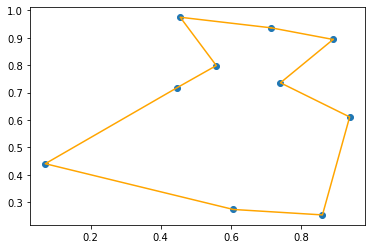

In [7]:
## solve with Simulated Annealing
best = simann(tsp_small, mcmc_steps = 5000, anneal_steps = 50, beta0 = 2.0, beta1 = 45.0,
                     seed = 456) 
## Simulated Annealing  Solution
best.display()
print(f"final cost = {best.cost()} ")

final cost = 2.8872363215071424


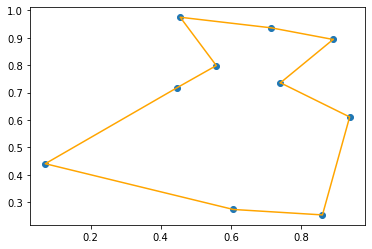

In [8]:
## Greedy Solution
best_g = greedy(tsp_small, num_iters = 50000, repeats = 3, visualize_progress=True) 

<font color='#2874A6' size=5>
Now we move on to a larger problem of 100 cities
</font> 


In [9]:
## Generate a problem 100 cities
tsp_large = TSP(100, seed=456329)

final cost = 7.884959113283537 


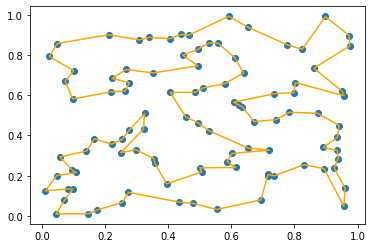

In [10]:
## takes arround 10 minutes to run
## we can achive good results in much less time but this seems to be the best result consistently
best = simann(tsp_large, mcmc_steps = 40000, anneal_steps = 500, beta0 = 2.0, beta1 = 45.0,
                     seed = 456) 

## Simulated Annealing  Solution
best.display()
print(f"final cost = {best.cost()} ")

final cost = 8.034544635018097


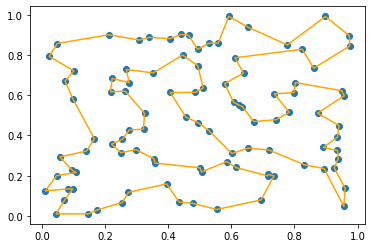

In [12]:
## Greedy Solution
## Takes arround 2 minutes to run
best_g = greedy(tsp_large, num_iters = 100000, repeats = 30, visualize_progress=False) 


<font color='#2874A6' size=5>
SA achived better results and was able to overcome local minima
</font> 
